In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import PreTrainedModel, PretrainedConfig
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import numpy as np

2025-05-17 14:39:03.926202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747463943.938892  153336 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747463943.942735  153336 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747463943.953214  153336 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747463943.953230  153336 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747463943.953231  153336 computation_placer.cc:177] computation placer alr

In [2]:
class CNNConfig(PretrainedConfig):
    model_type = "cnn"

    def __init__(self, input_length=512, num_labels=3, **kwargs):
        super().__init__(**kwargs)
        self.input_length = input_length
        self.num_labels = num_labels

class CNNForSequenceClassification(PreTrainedModel):
    config_class = CNNConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.conv1 = nn.Conv1d(1, 512, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)

        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv1d(512, 256, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)

        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.drop4 = nn.Dropout(0.2)

        self.conv5 = nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.pool5 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.drop5 = nn.Dropout(0.2)

        # Compute flattened output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, config.input_length)
            x = self._forward_features(dummy)
            self.flattened_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, config.num_labels)

        self.post_init()

    def _forward_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.drop4(x)
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.drop5(x)
        return x

    def forward(self, input_values=None, labels=None):
        x = input_values.unsqueeze(1)  # (B, 1, T)
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))
        logits = self.fc2(x)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {"input_values": self.X[idx], "labels": self.y[idx]}

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = CNNConfig.from_pretrained('./dabloat-cnn-emotion-aug')
model = CNNForSequenceClassification(config=config)
model = model.to(device) 

In [5]:
state_dict = torch.load('./dabloat-cnn-emotion-aug.pth', map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
data = pd.read_csv('test_emotions.csv')
data.fillna(0, inplace=True)
data

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.025391,0.031738,0.038574,0.026855,0.026855,0.034668,0.045410,0.054199,0.059082,0.057617,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,negative
1,0.150391,0.162598,0.180176,0.073730,0.064941,0.065430,0.068848,0.070801,0.080078,0.097656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,positive
2,0.019043,0.024414,0.032715,0.034668,0.035156,0.037109,0.035645,0.035156,0.030273,0.038086,...,-11.658588,-0.967232,-9.198069,-2.373846,-9.807080,10.628701,-1.992553,0.143462,2.126044,neutral
3,0.018066,0.030762,0.062012,0.082031,0.104004,0.129883,0.125000,0.112305,0.090820,0.068848,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,positive
4,0.019043,0.028809,0.041016,0.042480,0.041992,0.042480,0.040527,0.040527,0.041992,0.042969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,0.018066,0.026367,0.037598,0.037598,0.040039,0.040527,0.041992,0.043457,0.043457,0.042969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,positive
4612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.395961,-3.695465,-3.683924,-3.430692,-3.029513,-2.550655,-2.041340,-1.551488,-1.130006,neutral
4613,0.040527,0.057617,0.067383,0.055664,0.067383,0.079590,0.096680,0.104004,0.083496,0.063965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,positive
4614,0.015137,0.025391,0.034668,0.034668,0.040527,0.039551,0.038086,0.037598,0.032715,0.031250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [9]:
X = data.iloc[: ,:-1].values
Y = data['Emotions'].values

In [10]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

In [66]:
x_test[0].shape

(2376,)

In [13]:
x_test, y_test = X, Y
val_dataset = EmotionDataset(x_test, y_test)

In [55]:
val_dataset[0]['input_values'].shape

torch.Size([2376])

In [14]:
training_args = TrainingArguments(
    output_dir="./cnn_eval_output",
    per_device_eval_batch_size=32,
    dataloader_drop_last=False,
    do_train=False,
    do_eval=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset
)

In [15]:
eval_results = trainer.evaluate()
print("Eval Results:", eval_results)

Eval Results: {'eval_loss': 0.1856144219636917, 'eval_model_preparation_time': 0.0008, 'eval_runtime': 5.3466, 'eval_samples_per_second': 863.348, 'eval_steps_per_second': 27.12}


In [16]:
predictions = trainer.predict(val_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
true = predictions.label_ids

              precision    recall  f1-score   support

           0     0.9661    0.9252    0.9452      1538
           1     0.9598    0.9929    0.9760      1539
           2     0.9626    0.9701    0.9663      1539

    accuracy                         0.9627      4616
   macro avg     0.9628    0.9627    0.9625      4616
weighted avg     0.9628    0.9627    0.9625      4616



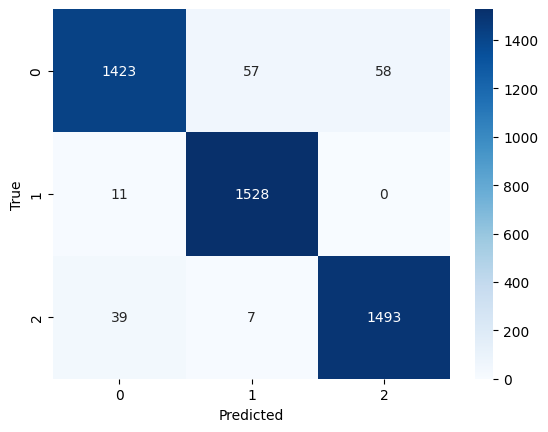

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(true, preds, digits=4))
sns.heatmap(confusion_matrix(true, preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [263]:
class DaBloatCNNPipeline:
    def __init__(self):
        self.sentiment = {0:'negative', 1:'neutral', 2:'positive'}
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.frame_length = 2048
        self.hop_length = 512
        self.training_args = TrainingArguments(
                            output_dir="./cnn_eval_output",
                            per_device_eval_batch_size=32,
                            dataloader_drop_last=False,
                            do_train=False,
                            do_eval=True,
                            report_to="none"
                        )
        self.config = CNNConfig.from_pretrained('dabloat-cnn-emotion-aug')
        self.weights = torch.load('./dabloat-cnn-emotion-aug.pth', map_location=self.device)
        self.model = CNNForSequenceClassification(config=self.config).to(self.device)
        self.model.load_state_dict(self.weights)
        self.predictor = Trainer(
                model=self.model,
                args=self.training_args,
        )
        
    def zero_crossing_rate(self, data, fr_len, hop_len):
        zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=fr_len, hop_length=hop_len)
        return np.squeeze(zcr)
    
    def root_mean_square(self, data, fr_len, hop_len):
        rms = librosa.feature.rms(y=data, frame_length=fr_len, hop_length=hop_len)
        return np.squeeze(rms)
    
    def mfcc(self, data, sr, flatten=True):
        mfcc = librosa.feature.mfcc(y=data, sr=sr)
        return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)
    
    def extract(self, data,sr=16000, fr_len=2048, hop_len=512):
        res = np.array([])
        result = np.hstack((
            res,
            self.zero_crossing_rate(data, fr_len, hop_len),
            self.root_mean_square(data, fr_len, hop_len),
            self.mfcc(data, sr)
        ))
        return result
    
    def process_test(self, path):
        data, sr = librosa.load(path, duration=2.5, offset=0.6)
        feat = self.extract(data)
        return np.pad(feat, (0, 2376 - feat.shape[0]), 'constant')
    
    def predict_sentiment(self, path):
        aud_data = [self.process_test(path)]
        dummy_emotion = [0]
        data_pred = EmotionDataset(aud_data, dummy_emotion)
        pred = self.predictor.predict(data_pred)
        summary = pred.predictions
        return {'prediction':summary, 'sentiment':self.sentiment[np.argmax(summary)]}

In [264]:
classify = DaBloatCNNPipeline()

# CREMA CHECK

In [267]:
n_crema = 12
crema = pd.read_csv('datasets/crema.csv')
crema_neut = crema[crema['sentiment'] == 'neutral'].iloc[n_crema]
crema_neg = crema[crema['sentiment'] == 'negative'].iloc[n_crema]
crema_pos = crema[crema['sentiment'] == 'positive'].iloc[n_crema]

In [268]:
print(crema_neut['sentiment'])
classify.predict_sentiment(crema_neut['file_path'])

neutral


{'prediction': array([[ -3.2204607,  10.549007 , -11.867853 ]], dtype=float32),
 'sentiment': 'neutral'}

In [269]:
print(crema_neg['sentiment'])
classify.predict_sentiment(crema_neg['file_path'])

negative


{'prediction': array([[ 5.1789975, -9.509143 , -5.855053 ]], dtype=float32),
 'sentiment': 'negative'}

In [270]:
print(crema_pos['sentiment'])
classify.predict_sentiment(crema_pos['file_path'])

positive


{'prediction': array([[ -2.9018726, -11.559529 ,   5.1159534]], dtype=float32),
 'sentiment': 'positive'}

# RAVNESS CHECK

In [253]:
ravdess = pd.read_csv('datasets/ravdess.csv')
ravdess_neut = ravdess[ravdess['sentiment'] == 'neutral'].iloc[12]
ravdess_neg = ravdess[ravdess['sentiment'] == 'negative'].iloc[12]
ravdess_pos = ravdess[ravdess['sentiment'] == 'positive'].iloc[12]

In [271]:
print(ravdess_neut['sentiment'])
classify.predict_sentiment(ravdess_neut['file_path'])

neutral


{'prediction': array([[-3.3947773,  7.4861217, -5.525408 ]], dtype=float32),
 'sentiment': 'neutral'}

In [272]:
print(ravdess_neg['sentiment'])
classify.predict_sentiment(ravdess_neg['file_path'])

negative


{'prediction': array([[ 13.430473, -20.35952 ,  -8.862479]], dtype=float32),
 'sentiment': 'negative'}

In [273]:
print(ravdess_pos['sentiment'])
classify.predict_sentiment(ravdess_pos['file_path'])

positive


{'prediction': array([[ -1.018823, -14.718866,   5.930568]], dtype=float32),
 'sentiment': 'positive'}

# SAVEE CHECK

In [275]:
savee = pd.read_csv('datasets/savee.csv')
savee_neut = savee[savee['sentiment'] == 'neutral'].iloc[12]
savee_neg = savee[savee['sentiment'] == 'negative'].iloc[12]
savee_pos = savee[savee['sentiment'] == 'positive'].iloc[12]

In [276]:
print(savee_neut['sentiment'])
classify.predict_sentiment(savee_neut['file_path'])

neutral


{'prediction': array([[ -7.664056,  17.72554 , -11.095494]], dtype=float32),
 'sentiment': 'neutral'}

In [278]:
print(savee_neg['sentiment'])
classify.predict_sentiment(savee_neg['file_path'])

negative


{'prediction': array([[ 4.3383565, -6.510544 , -9.738879 ]], dtype=float32),
 'sentiment': 'negative'}

In [279]:
print(savee_pos['sentiment'])
classify.predict_sentiment(savee_pos['file_path'])

positive


{'prediction': array([[ -2.7136152, -11.944947 ,   3.06334  ]], dtype=float32),
 'sentiment': 'positive'}

# TESS CHECK

In [280]:
tess = pd.read_csv('datasets/tess.csv')
tess_neut = tess[tess['sentiment'] == 'neutral'].iloc[12]
tess_neg = tess[tess['sentiment'] == 'negative'].iloc[12]
tess_pos = tess[tess['sentiment'] == 'positive'].iloc[12]

In [281]:
print(tess_neut['sentiment'])
classify.predict_sentiment(tess_neut['file_path'])

neutral


{'prediction': array([[-4.7823772,  9.014636 , -9.376236 ]], dtype=float32),
 'sentiment': 'neutral'}

In [282]:
print(tess_neg['sentiment'])
classify.predict_sentiment(tess_neg['file_path'])

negative


{'prediction': array([[  8.701019, -11.025155,  -9.525874]], dtype=float32),
 'sentiment': 'negative'}

In [283]:
print(tess_pos['sentiment'])
classify.predict_sentiment(tess_pos['file_path'])

positive


{'prediction': array([[ -6.4156103, -22.105927 ,  11.426043 ]], dtype=float32),
 'sentiment': 'positive'}

In [25]:
# Created by DaBloat